## Notebook reads in CERES albedo and insolation data, and calculates and plots the expected radiative forcing from uniform and sinusoidal reductions in insolation. 

Author: Alistair Duffey, alistair.duffey.21@ucl.ac.uk

In [1]:
import numpy as np
from netCDF4 import Dataset as NetCDFFile 
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cmaps
import climlab
#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)

earth_rad = 6371000

albedo_data_monthly_zonal = "data/CERES_SSF1deg-Month_Terra-MODIS_Ed4.1_Subset_200101-202201.nc"
albedo = NetCDFFile(albedo_data_monthly_zonal)
DS = xr.open_dataset(albedo_data_monthly_zonal)
albedo_monthly_decadal_avg = DS.groupby("time.month").mean(dim="time")
albedo_monthly_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)'] = (1-albedo_monthly_decadal_avg['ztoa_alb_all_mon']) * albedo_monthly_decadal_avg['ztoa_solar_all_mon'] * 0.01
albedo_annual_decadal_avg = albedo_monthly_decadal_avg.groupby("lat").mean(dim="month")
albedo_JJA_decadal_avg = albedo_monthly_decadal_avg.sel(month = slice(6,8)).groupby("lat").mean(dim="month")
albedo_DJF_decadal_avg = albedo_monthly_decadal_avg.sel(month = [12, 1, 2]).groupby("lat").mean(dim="month")

max_SW_forcing_decadal_avg = albedo_monthly_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)'].groupby("lat").max(dim="month")
sinusoidal_forcing = 2*np.abs(np.sin(np.deg2rad(albedo_annual_decadal_avg['lat'])))



In [2]:
# define useful plotting legend tidying function
def legend_without_duplicate_labels(ax, loc=None):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    if loc:
        ax.legend(*zip(*unique), loc=loc)
    else:
        ax.legend(*zip(*unique))

In [3]:
albedo_annual_decadal_avg['zonally integrated SW forcing per 1% reduction in insolation (TW/deg lat)'] = (albedo_annual_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)']*
                                                                        np.cos(np.deg2rad(albedo_annual_decadal_avg['lat']))*
                                                                        np.deg2rad(1)*2*np.pi*earth_rad**2/(10**12))

max_SW_forcing_zonally_int_decadal_avg = (max_SW_forcing_decadal_avg*
                                                    np.cos(np.deg2rad(albedo_annual_decadal_avg['lat']))*
                                                    np.deg2rad(1)*2*np.pi*earth_rad**2/(10**12))

albedo_annual_decadal_avg['zonally integrated SW forcing with sin reduction in insolation (TW/deg lat)'] = (albedo_annual_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)']*
                                                                        np.cos(np.deg2rad(albedo_annual_decadal_avg['lat']))*sinusoidal_forcing*
                                                                        np.deg2rad(1)*2*np.pi*earth_rad**2/(10**12))


In [4]:
lats = np.arange(0,91,1)
i=0
cum_sumN = np.zeros(len(lats))
cum_sumS = np.zeros(len(lats))
for x in lats:
    slceN = albedo_annual_decadal_avg.sel(lat=slice(0, lats[i]))
    slceS = albedo_annual_decadal_avg.sel(lat=slice(-lats[i], 0))
    cum_sumN[i] = np.sum(slceN['zonally integrated SW forcing per 1% reduction in insolation (TW/deg lat)'])
    cum_sumS[i] = np.sum(slceS['zonally integrated SW forcing per 1% reduction in insolation (TW/deg lat)'])
    i = i+1
    
cum_sumN = 100*cum_sumN/np.max(cum_sumN)
cum_sumS = 100*cum_sumS/np.max(cum_sumS)

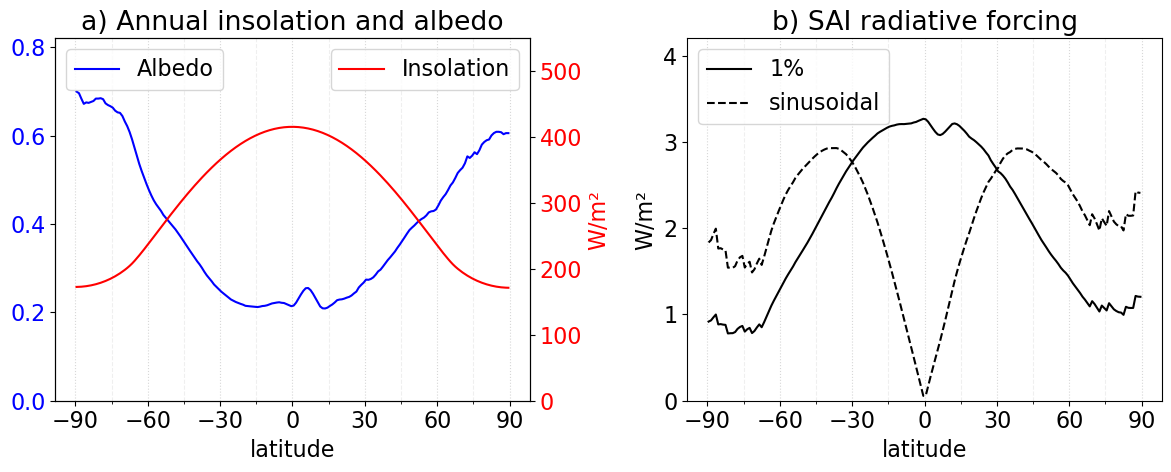

In [5]:
plt.rcParams.update({'font.size': 16})
x1 = albedo_annual_decadal_avg['ztoa_alb_all_mon']
x2 = albedo_annual_decadal_avg['ztoa_solar_all_mon']
x3 = albedo_JJA_decadal_avg['ztoa_alb_all_mon'].sel(lat=slice(30, 90))
x4 = albedo_JJA_decadal_avg['ztoa_solar_all_mon'].sel(lat=slice(30, 90))
x5 = albedo_DJF_decadal_avg['ztoa_alb_all_mon'].sel(lat=slice(-90, -30))
x6 = albedo_DJF_decadal_avg['ztoa_solar_all_mon'].sel(lat=slice(-90, -30))

z1 = albedo_annual_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)']
z2 = albedo_annual_decadal_avg['zonally integrated SW forcing per 1% reduction in insolation (TW/deg lat)']
z3 = max_SW_forcing_decadal_avg
z4 = max_SW_forcing_zonally_int_decadal_avg

w1 = sinusoidal_forcing
w2 = albedo_annual_decadal_avg['SW forcing per 1% reduction in insolation (W/m2)']*sinusoidal_forcing

def two_scales(ax1, xaxis, data1, data2, c1, c2, data1_b=None, data2_b=None, data1_label=None, data2_label=None, data1_b_label=None, data2_b_label=None):
    ax2 = ax1.twinx()
    ax1.plot(xaxis, data1, color=c1, label=data1_label)
    ax2.plot(xaxis, data2, color=c2, label=data2_label)
    if data1_b is not None:
        ax1.plot(xaxis, data1_b, color=c1, linestyle='--', label=data1_b_label)
    if data2_b is not None:
        ax2.plot(xaxis, data2_b, color=c2, linestyle='--', label=data2_b_label)
    return ax1, ax2

def add_x_grid(ax):
    ax.set_xticks(ticks=np.arange(-90, 91, 30), major=True)
    ax.set_xticks(ticks=np.arange(-90, 91, 15), minor=True)
    ax.grid(which='minor', axis='x', alpha=0.2, linestyle='--')
    ax.grid(which='major', axis='x', alpha=0.5, linestyle=':')
    return

# Create axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

### first plot
ax1a = ax1.twinx()
ax1.plot(x1['lat'], x1, color='b', label="Albedo")
#ax1.plot(x3['lat'], x3, color='b', label="Albedo local summer", linestyle='--')
#ax1.plot(x5['lat'], x5, color='b', label="Albedo local summer", linestyle='--')


ax1a.plot(x1['lat'], x2, color='r', label="Insolation")
#ax1a.plot(x4['lat'], x4, color='r', label="Insolation local summer", linestyle='--')
#ax1a.plot(x6['lat'], x6, color='r', label="Insolation local summer", linestyle='--')

#ax1.legend(loc=2)
legend_without_duplicate_labels(ax1, loc=2)
ax1.set_ylim(0,0.82)
legend_without_duplicate_labels(ax1a, loc=1)
#ax1a.legend(loc=1)
ax1.set_xlabel('latitude')
ax1a.set_ylabel('W/m\u00b2')
ax1a.set_ylim(0, 550)
ax1.set_title('a) Annual insolation and albedo')#, fontweight="bold")
add_x_grid(ax1)

### second plot
#ax2a = ax2.twinx()
ax2.plot(z1['lat'], z1, color='black', label="1%")
ax2.plot(z1['lat'], w2, color='black', linestyle='--', label="sinusoidal")
#ax2a.plot(z1['lat'], w1, color='r', linestyle='--', label="sinusoidal")
#ax2a.plot(z1['lat'], np.ones(len(z1['lat'])), color='r', label="1%")
ax2.legend(loc=2)
#ax2a.legend(loc=1)
ax2.set_xlabel('latitude')
ax2.set_ylabel('W/m\u00b2')
#ax2a.set_ylabel('% insolation reduction')
ax2.set_ylim(0,4.2)
#ax2a.set_ylim(0,3)
ax2.set_title('b) SAI radiative forcing')
#ax2a.set_yticks(ticks=[0, 5, 10, 15])
add_x_grid(ax2)


### add colours to axes
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    ax.yaxis.label.set_color(color) 

color_y_axis(ax1, 'b')
color_y_axis(ax1a, 'r')
color_y_axis(ax2, 'black')
#color_y_axis(ax2a, 'r')





plt.tight_layout()
plt.show()
fig.savefig('insolation_albedo_SAI_forcing_panels_v2.jpg', dpi=600)